In [3]:
import os
import sys

import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
from tqdm import tqdm
import itertools

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleStrongLens
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import gs

In [4]:
pipeline_params = util.hydra_to_dict(config.pipeline)
debugging = pipeline_params['debugging']
if debugging:
    pipeline_dir = f'{config.machine.pipeline_dir}_dev'
else:
    pipeline_dir = config.machine.pipeline_dir

survey_params = util.hydra_to_dict(config.survey)
# pprint(survey_params)

source_cut_band = survey_params['source_cut_band']
deflector_cut_band = survey_params['deflector_cut_band']

# combine CSVs from each run into one CSV
data_dir = os.path.join(pipeline_dir, '00')
detectable_csv = os.path.join(data_dir, 'detectable_pop.csv')
util.delete_if_exists(detectable_csv)
detectable_df = util.combine_all_csvs(data_dir, 'detectable', detectable_csv)
detectable_df.replace([np.inf, -np.inf], np.nan, inplace=True)
detectable_df = detectable_df.dropna()  # remove any nan SNRs
if survey_params['total_population']:
    total_csv = os.path.join(data_dir, 'total_pop.csv')
    util.delete_if_exists(total_csv)
    total_df = util.combine_all_csvs(data_dir, 'total', total_csv)
    total_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    total_df = total_df.dropna()

# detectable lenses
velocity_dispersions = detectable_df.loc[:,'velodisp']
masses = detectable_df.loc[:,'massstel'] * 1e12
source_redshifts = detectable_df.loc[:,'redssour']
lens_redshifts = detectable_df.loc[:,'redslens']
einstein_radii = detectable_df.loc[:,'angleins']
num_images = detectable_df.loc[:,'numbimag']
source_magnitudes = detectable_df.loc[:,f'magtsour{source_cut_band}']
lens_magnitudes = detectable_df.loc[:,f'magtlens{deflector_cut_band}']
snrs = detectable_df.loc[:,'snr']
magnification = detectable_df.loc[:,'magnsour']

# total lenses
if survey_params['total_population']:
    total_velocity_dispersions = total_df.loc[:,'velodisp']
    total_masses = total_df.loc[:,'massstel'] * 1e12
    total_source_redshifts = total_df.loc[:,'redssour']
    total_lens_redshifts = total_df.loc[:,'redslens']
    total_einstein_radii = total_df.loc[:,'angleins']
    total_num_images = total_df.loc[:,'numbimag']
    total_source_magnitudes = total_df.loc[:,f'magtsour{source_cut_band}']
    total_lens_magnitudes = total_df.loc[:,f'magtlens{deflector_cut_band}']
    total_snrs = total_df.loc[:,'snr']
    total_magnification = total_df.loc[:,'magnsour']

# snr_files = glob(f'{data_dir}/snr_list_*.npy')
# snr_list = list(itertools.chain.from_iterable([np.load(f) for f in snr_files]))

Wrote combined CSV to /data/bwedig/mejiro/pipeline/00/detectable_pop.csv


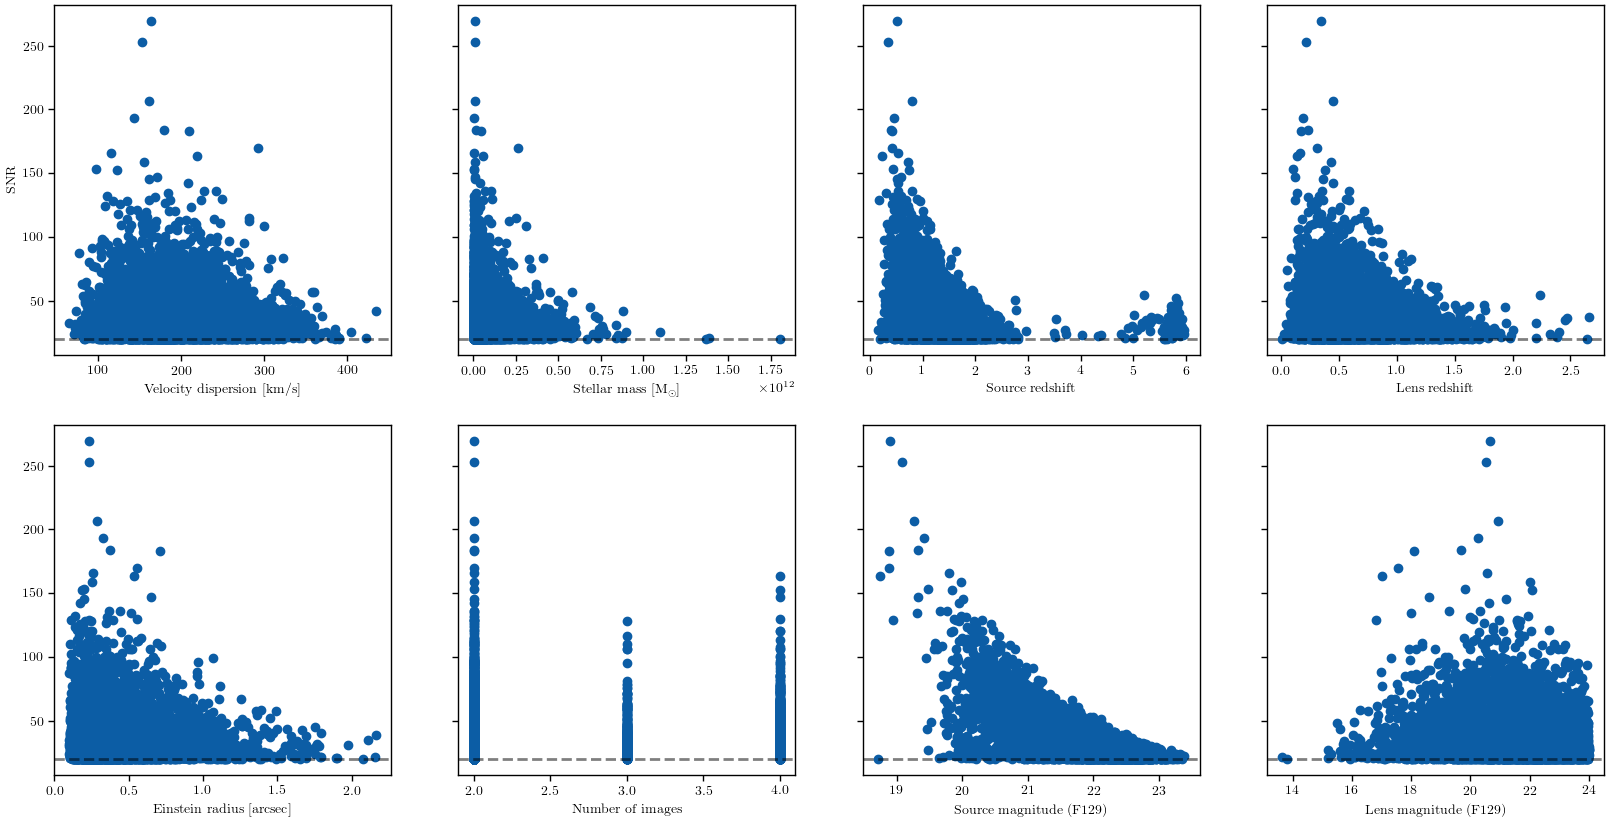

In [5]:
_, ax = plt.subplots(2, 4, figsize=(20, 10), sharey=True)

color_detectable = 'C0'
color_total = 'C1'

if survey_params['total_population']:
    ax[0, 0].scatter(total_velocity_dispersions, total_snrs, color=color_total)
    ax[0, 1].scatter(total_masses, total_snrs, color=color_total)
    ax[0, 2].scatter(total_source_redshifts, total_snrs, color=color_total)
    ax[0, 3].scatter(total_lens_redshifts, total_snrs, color=color_total)
    ax[1, 0].scatter(total_einstein_radii, total_snrs, color=color_total)
    ax[1, 1].scatter(total_num_images, total_snrs, color=color_total)
    ax[1, 2].scatter(total_source_magnitudes, total_snrs, color=color_total)
    ax[1, 3].scatter(total_lens_magnitudes, total_snrs, color=color_total)

ax[0, 0].scatter(velocity_dispersions, snrs, color=color_detectable)
ax[0, 0].set_xlabel('Velocity dispersion [km/s]')
ax[0, 0].set_ylabel('SNR')

ax[0, 1].scatter(masses, snrs, color=color_detectable)
ax[0, 1].set_xlabel('Stellar mass [M$_\odot$]')

ax[0, 2].scatter(source_redshifts, snrs, color=color_detectable)
ax[0, 2].set_xlabel('Source redshift')

ax[0, 3].scatter(lens_redshifts, snrs, color=color_detectable)
ax[0, 3].set_xlabel('Lens redshift')

ax[1, 0].scatter(einstein_radii, snrs, color=color_detectable)
ax[1, 0].set_xlabel('Einstein radius [arcsec]')

ax[1, 1].scatter(num_images, snrs, color=color_detectable)
ax[1, 1].set_xlabel('Number of images')

ax[1, 2].scatter(source_magnitudes, snrs, color=color_detectable)
ax[1, 2].set_xlabel(f'Source magnitude ({source_cut_band})')

ax[1, 3].scatter(lens_magnitudes, snrs, color=color_detectable)
ax[1, 3].set_xlabel(f'Lens magnitude ({deflector_cut_band})')

for i in range(4):
    for j in range(2):
        ax[j, i].axhline(20, color='k', alpha=0.5, linestyle='--')

plt.savefig(os.path.join(figure_dir, 'snr_cross_correlation.png'))
plt.show()

In [6]:
num_inf_rows = detectable_df[detectable_df.isin([np.inf]).any(axis=1)].shape[0]
assert num_inf_rows == 0, f'Found {num_inf_rows} rows with inf values in detectable_df'

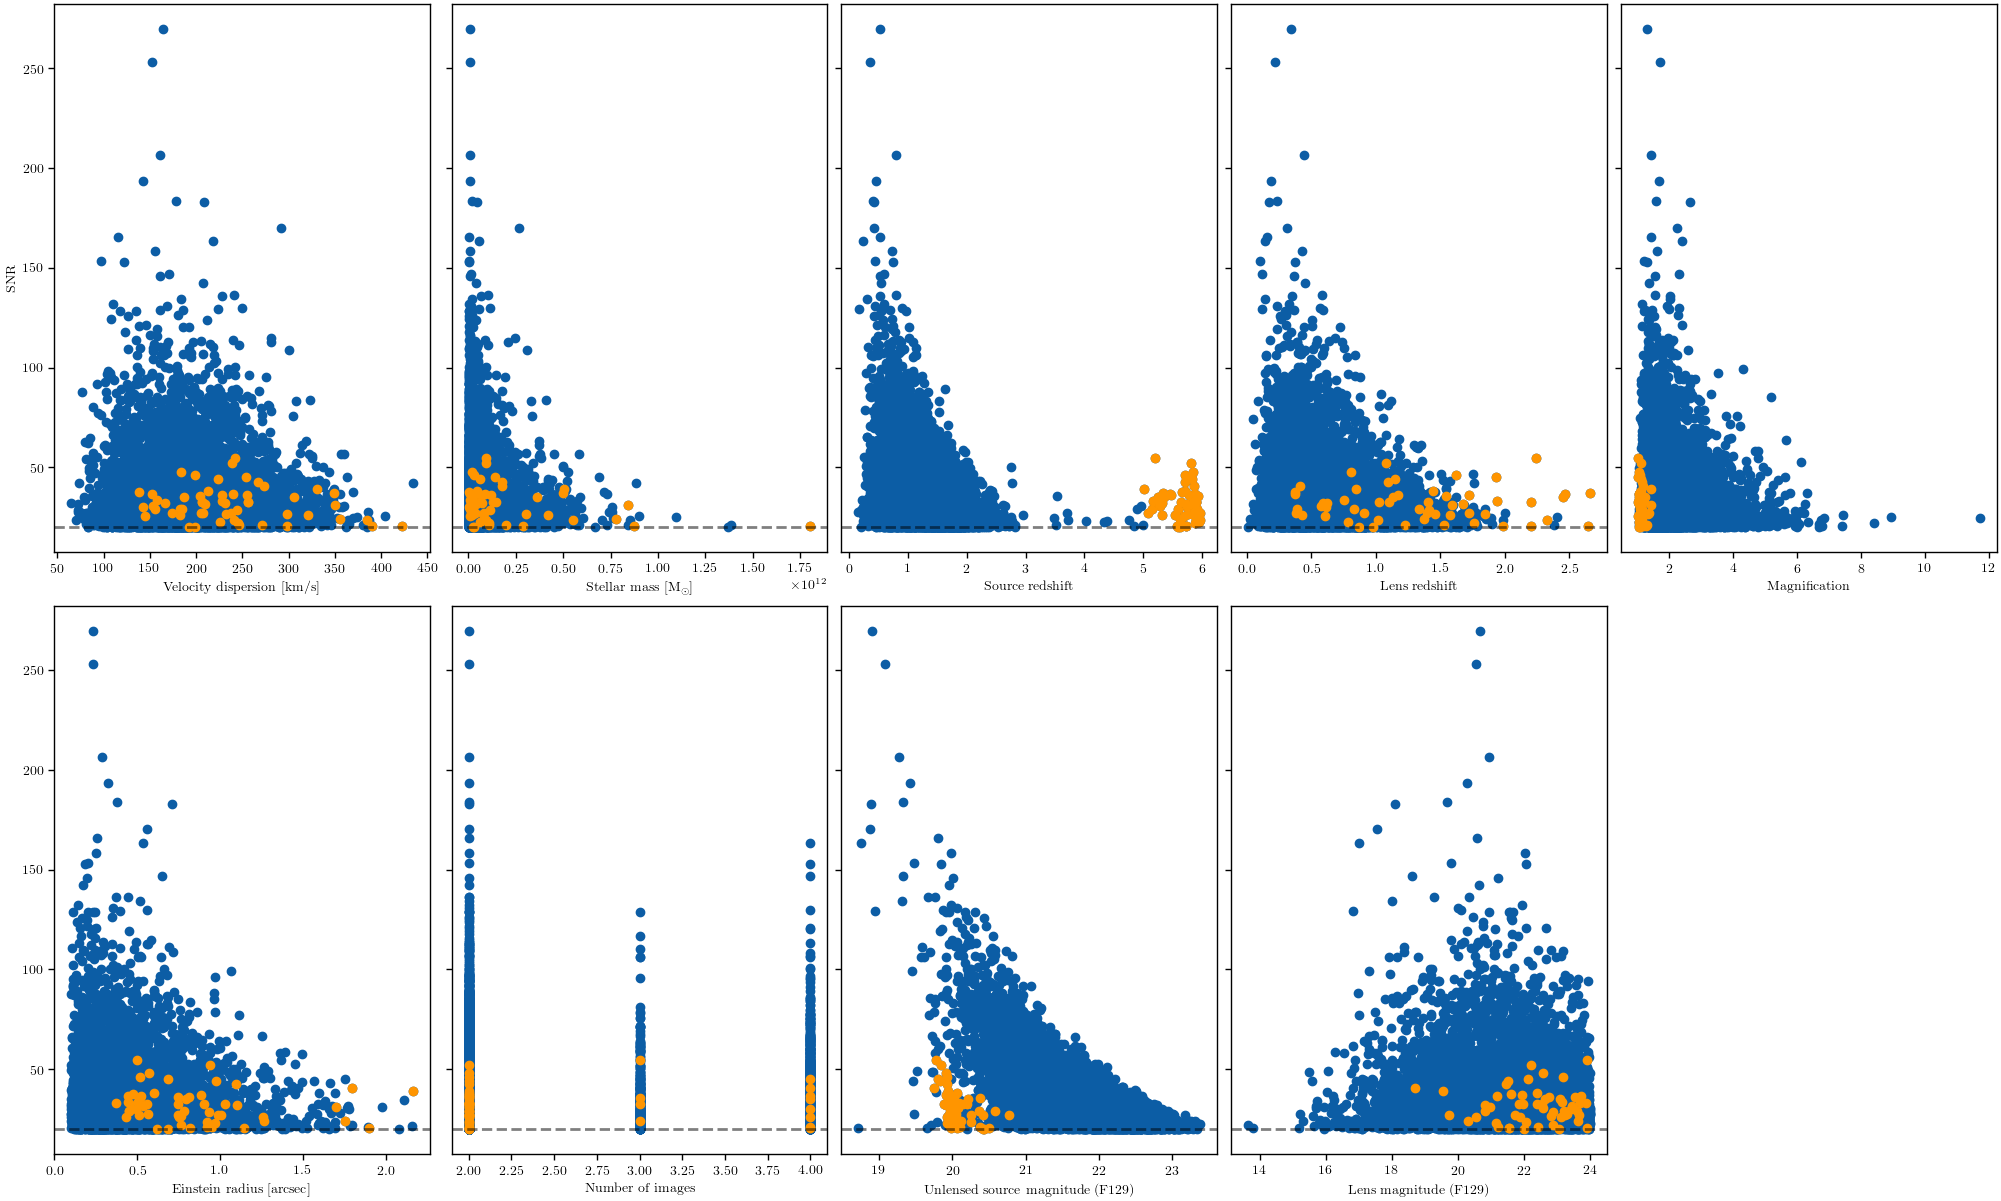

In [7]:
high_source_redshift = detectable_df.loc[detectable_df['redssour'] > 5]
high_source_redshift_snrs = high_source_redshift.loc[:,'snr']

_, ax = plt.subplots(2, 5, figsize=(20, 12), sharey=True, constrained_layout=True)

color_high_source_redshift = 'C2'

ax[0, 0].scatter(velocity_dispersions, snrs, color=color_detectable)
ax[0, 0].scatter(high_source_redshift.loc[:,'velodisp'], high_source_redshift_snrs, color=color_high_source_redshift)
ax[0, 0].set_xlabel('Velocity dispersion [km/s]')
ax[0, 0].set_ylabel('SNR')

ax[0, 1].scatter(masses, snrs, color=color_detectable)
ax[0, 1].scatter(high_source_redshift.loc[:,'massstel'] * 1e12, high_source_redshift_snrs, color=color_high_source_redshift)
ax[0, 1].set_xlabel('Stellar mass [M$_\odot$]')

ax[0, 2].scatter(source_redshifts, snrs, color=color_detectable)
ax[0, 2].scatter(high_source_redshift.loc[:,'redssour'], high_source_redshift_snrs, color=color_high_source_redshift)
ax[0, 2].set_xlabel('Source redshift')

ax[0, 3].scatter(lens_redshifts, snrs, color=color_detectable)
ax[0, 3].scatter(high_source_redshift.loc[:,'redslens'], high_source_redshift_snrs, color=color_high_source_redshift)
ax[0, 3].set_xlabel('Lens redshift')

ax[0, 4].scatter(magnification, snrs, color=color_detectable)
ax[0, 4].scatter(high_source_redshift.loc[:,'magnsour'], high_source_redshift_snrs, color=color_high_source_redshift)
ax[0, 4].set_xlabel('Magnification')

ax[1, 0].scatter(einstein_radii, snrs, color=color_detectable)
ax[1, 0].scatter(high_source_redshift.loc[:,'angleins'], high_source_redshift_snrs, color=color_high_source_redshift)
ax[1, 0].set_xlabel('Einstein radius [arcsec]')

ax[1, 1].scatter(num_images, snrs, color=color_detectable)
ax[1, 1].scatter(high_source_redshift.loc[:,'numbimag'], high_source_redshift_snrs, color=color_high_source_redshift)
ax[1, 1].set_xlabel('Number of images')

ax[1, 2].scatter(source_magnitudes, snrs, color=color_detectable)
ax[1, 2].scatter(high_source_redshift.loc[:,f'magtsour{source_cut_band}'], high_source_redshift_snrs, color=color_high_source_redshift)
ax[1, 2].set_xlabel(f'Unlensed source magnitude ({source_cut_band})')

ax[1, 3].scatter(lens_magnitudes, snrs, color=color_detectable)
ax[1, 3].scatter(high_source_redshift.loc[:,f'magtlens{deflector_cut_band}'], high_source_redshift_snrs, color=color_high_source_redshift)
ax[1, 3].set_xlabel(f'Lens magnitude ({deflector_cut_band})')

ax[1, 4].set_axis_off()

for i in range(4):
    for j in range(2):
        ax[j, i].axhline(20, color='k', alpha=0.5, linestyle='--')

plt.savefig(os.path.join(figure_dir, 'snr_cross_correlation_high_source_redshift.png'))
plt.show()

In [8]:
from mejiro.lenses import lens_util

detectable_lenses = lens_util.get_detectable_lenses(config.machine.pipeline_dir, limit=None, with_subhalos=True)
print(f'Number of detectable lenses: {len(detectable_lenses)}')

100%|██████████| 10071/10071 [02:02<00:00, 82.26it/s]

Number of detectable lenses: 10071


In [9]:
R_sersic_list, e1_list, e2_list, magnitude_list, n_sersic_list, snr_list = [], [], [], [], [], []
R_sersic_total_list, e1_total_list, e2_total_list, magnitude_total_list, n_sersic_total_list, snr_total_list = [], [], [], [], [], []

for lens in detectable_lenses:
    if lens.z_source > 5:
        R_sersic_list.append(lens.kwargs_source_dict['F129']['R_sersic'])
        e1_list.append(lens.kwargs_source_dict['F129']['e1'])
        e2_list.append(lens.kwargs_source_dict['F129']['e2'])
        magnitude_list.append(lens.kwargs_source_dict['F129']['magnitude'])
        n_sersic_list.append(lens.kwargs_source_dict['F129']['n_sersic'])
        snr_list.append(lens.snr)
    else:
        R_sersic_total_list.append(lens.kwargs_source_dict['F129']['R_sersic'])
        e1_total_list.append(lens.kwargs_source_dict['F129']['e1'])
        e2_total_list.append(lens.kwargs_source_dict['F129']['e2'])
        magnitude_total_list.append(lens.kwargs_source_dict['F129']['magnitude'])
        n_sersic_total_list.append(lens.kwargs_source_dict['F129']['n_sersic'])
        snr_total_list.append(lens.snr)

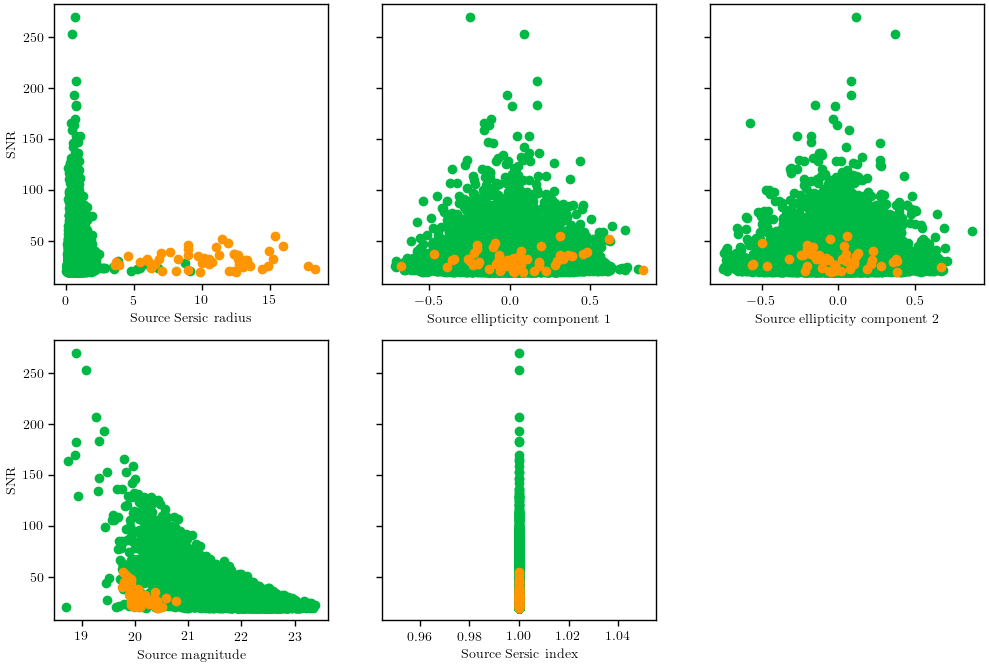

In [10]:
_, ax = plt.subplots(2, 3, figsize=(12, 8), sharey=True)

ax[0, 0].scatter(R_sersic_total_list, snr_total_list, color=color_total)
ax[0, 0].scatter(R_sersic_list, snr_list, color=color_high_source_redshift)
ax[0, 0].set_xlabel('Source Sersic radius')
ax[0, 0].set_ylabel('SNR')

ax[0, 1].scatter(e1_total_list, snr_total_list, color=color_total)
ax[0, 1].scatter(e1_list, snr_list, color=color_high_source_redshift)
ax[0, 1].set_xlabel('Source ellipticity component 1')

ax[0, 2].scatter(e2_total_list, snr_total_list, color=color_total)
ax[0, 2].scatter(e2_list, snr_list, color=color_high_source_redshift)
ax[0, 2].set_xlabel('Source ellipticity component 2')

ax[1, 0].scatter(magnitude_total_list, snr_total_list, color=color_total)
ax[1, 0].scatter(magnitude_list, snr_list, color=color_high_source_redshift)
ax[1, 0].set_xlabel('Source magnitude')
ax[1, 0].set_ylabel('SNR')

ax[1, 1].scatter(n_sersic_total_list, snr_total_list, color=color_total)
ax[1, 1].scatter(n_sersic_list, snr_list, color=color_high_source_redshift)
ax[1, 1].set_xlabel('Source Sersic index')

ax[1, 2].set_axis_off()

plt.savefig(os.path.join(figure_dir, 'snr_cross_correlation_high_source_redshift_source_properties.png'))
plt.show()

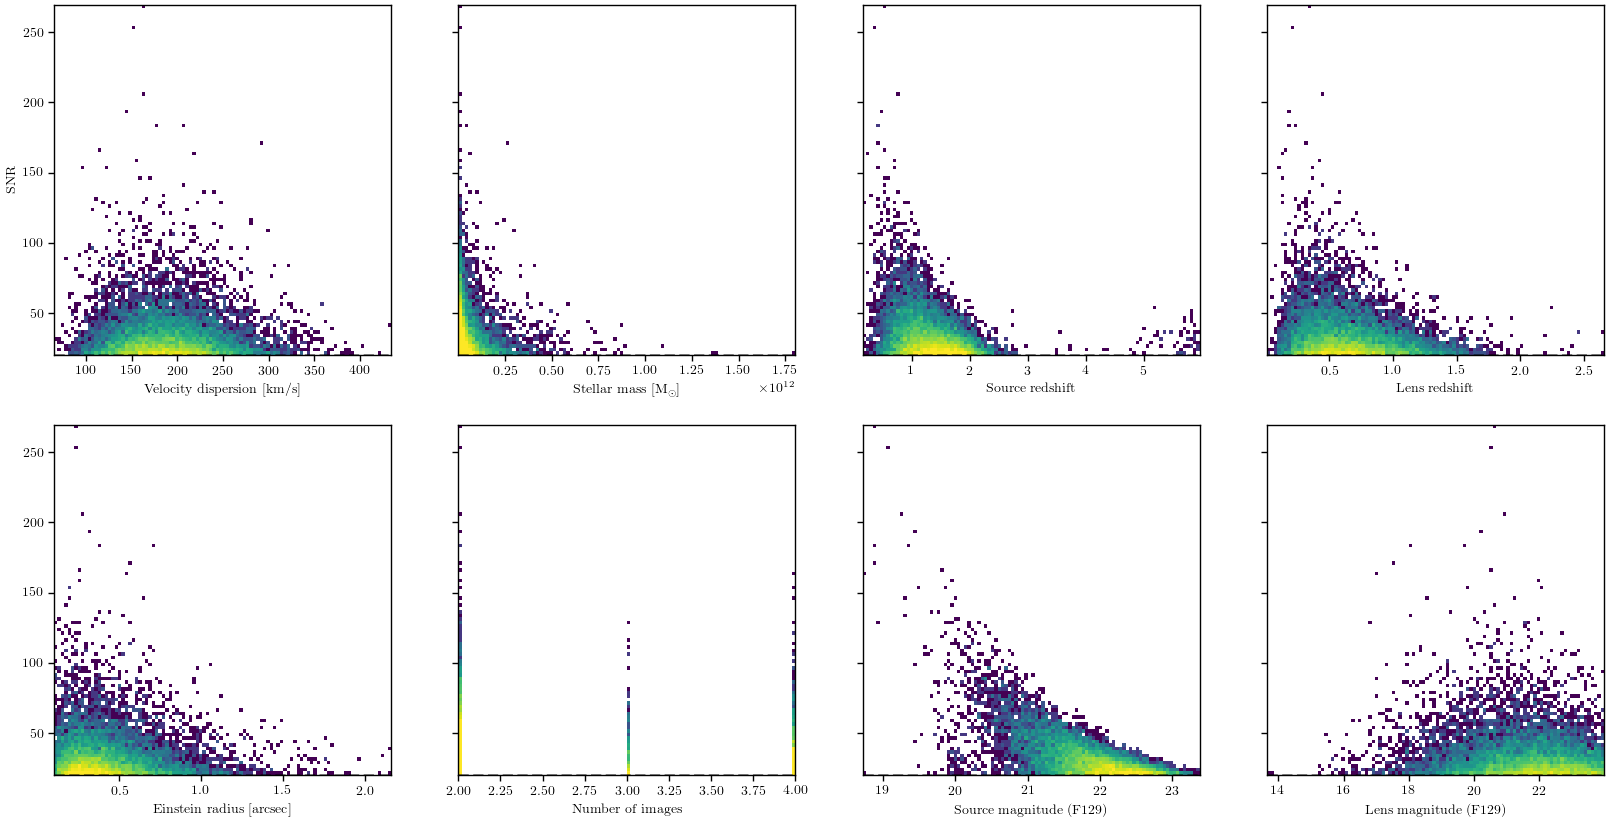

In [11]:
_, ax = plt.subplots(2, 4, figsize=(20, 10), sharey=True)

bins = round(np.sqrt(len(snrs)))
norm = colors.LogNorm()
# norm = colors.Normalize()

ax[0, 0].hist2d(velocity_dispersions, snrs, norm=norm, bins=bins)
ax[0, 0].set_xlabel('Velocity dispersion [km/s]')
ax[0, 0].set_ylabel('SNR')

ax[0, 1].hist2d(masses, snrs, norm=norm, bins=bins)
ax[0, 1].set_xlabel('Stellar mass [M$_\odot$]')

ax[0, 2].hist2d(source_redshifts, snrs, norm=norm, bins=bins)
ax[0, 2].set_xlabel('Source redshift')

ax[0, 3].hist2d(lens_redshifts, snrs, norm=norm, bins=bins)
ax[0, 3].set_xlabel('Lens redshift')

ax[1, 0].hist2d(einstein_radii, snrs, norm=norm, bins=bins)
ax[1, 0].set_xlabel('Einstein radius [arcsec]')

ax[1, 1].hist2d(num_images, snrs, norm=norm, bins=bins)
ax[1, 1].set_xlabel('Number of images')

ax[1, 2].hist2d(source_magnitudes, snrs, norm=norm, bins=bins)
ax[1, 2].set_xlabel(f'Source magnitude ({source_cut_band})')

ax[1, 3].hist2d(lens_magnitudes, snrs, norm=norm, bins=bins)
ax[1, 3].set_xlabel(f'Lens magnitude ({deflector_cut_band})')

for i in range(4):
    for j in range(2):
        ax[j, i].axhline(20, color='k', alpha=0.5, linestyle='--')

plt.savefig(os.path.join(figure_dir, 'snr_cross_correlation_heatmaps.png'))
plt.show()